Определим некоторые константы:

In [2]:
imsize = 71 #размер изображения

path = 'D:/myprog/practice2019/test/dataset' #путь к датасету

#названия ратений, а по совместительству и названия папок
#в данном случае можно использовать список
labels = {'Charlock': 0,
          'Common Chickweed': 1,
          'Common wheat': 2,
          'Maize': 3,
          'Scentless Mayweed': 4,
          'Small-flowered Cranesbill': 5,
          'Sugar beet': 6}

num_classes = len(labels) #количество видов растений

Напишем функцию для загрузки датасета:

In [3]:
import os
import cv2
import numpy as np

def load_data(path, folders):
    setsize = sum(len(os.listdir('{}/{}'.format(path, folder))) for folder in folders)
    images = np.zeros((setsize, imsize, imsize, 3), dtype=np.uint8)
    labels = np.zeros(setsize, dtype=np.int8)
    
    i = 0
    for folder in folders:
        for image_name in os.listdir('{}/{}'.format(path, folder)):
            image = cv2.imread('{}/{}/{}'.format(path, folder, image_name))
            images[i] = cv2.resize(image, (imsize, imsize))
            labels[i] = folders[folder]
            i += 1
    
    return images, labels

Загрузим датасет:

In [4]:
images, labels = load_data(path, labels)

Посмотрим, что получислось:

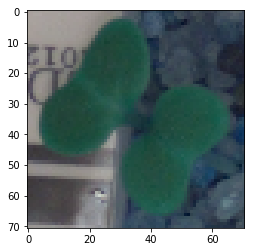

In [6]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.show()

Перемешаем выборку и преобразуем лейблы к one-hot encoding:

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=123)
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test  = np_utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [10]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(10, kernel_size=(3, 3), activation='relu', input_shape=(imsize, imsize, 3)))
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# model.add(Conv2D(10, kernel_size=(3, 3), activation='relu'))
# model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [56]:
batch_size = 8
epochs = 20
h = model.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test, Y_test))

Train on 2490 samples, validate on 831 samples
Epoch 1/20
2490/2490 [==============================] - 27s 11ms/step - loss: 12.6896 - acc: 0.2016 - val_loss: 12.6462 - val_acc: 0.2154
Epoch 2/20
2490/2490 [==============================] - 25s 10ms/step - loss: 12.6576 - acc: 0.2068 - val_loss: 12.3158 - val_acc: 0.2154
Epoch 3/20
2490/2490 [==============================] - 25s 10ms/step - loss: 2.0041 - acc: 0.3104 - val_loss: 1.3904 - val_acc: 0.4681
Epoch 4/20
2490/2490 [==============================] - 25s 10ms/step - loss: 1.3289 - acc: 0.4920 - val_loss: 1.2161 - val_acc: 0.6005
Epoch 5/20
2490/2490 [==============================] - 26s 10ms/step - loss: 1.1638 - acc: 0.5618 - val_loss: 1.0164 - val_acc: 0.6462
Epoch 6/20
2490/2490 [==============================] - 25s 10ms/step - loss: 1.0609 - acc: 0.6165 - val_loss: 1.0563 - val_acc: 0.6546
Epoch 7/20
2490/2490 [==============================] - 26s 10ms/step - loss: 0.9633 - acc: 0.6494 - val_loss: 0.8013 - val_acc: 0.72

Text(0, 0.5, 'Validation Accuracy')

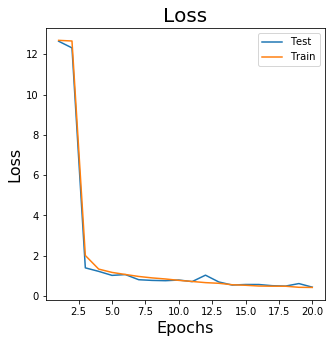

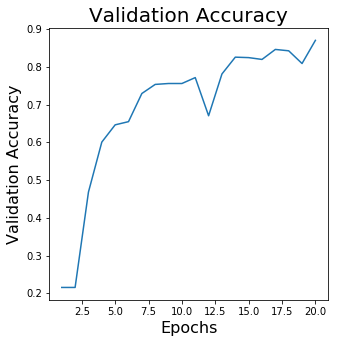

In [64]:
plt.figure(figsize=(5, 5))
plt.plot(range(1, epochs + 1), h.history['val_loss'], label='Test')
plt.plot(range(1, epochs + 1), h.history['loss'], label='Train')
plt.title('Loss', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()
plt.figure(figsize=(5, 5))
plt.plot(range(1, epochs + 1), h.history['val_acc'])
plt.title('Validation Accuracy', fontsize=20)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=16)

Точность не всегда является объективны показателем, посомотрим на матрицу ошибок:

In [65]:
from sklearn.metrics import classification_report

labels_pred = [np.argmax(pred) for pred in model.predict(X_test)]
labels_fact = [np.argmax(fact) for fact in Y_test]

print(classification_report(labels_fact, labels_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       103
           1       0.96      0.87      0.91       179
           2       0.87      0.94      0.91        72
           3       0.77      0.75      0.76        63
           4       0.78      0.87      0.82       157
           5       0.89      0.92      0.90       150
           6       0.90      0.78      0.83       107

   micro avg       0.87      0.87      0.87       831
   macro avg       0.87      0.86      0.86       831
weighted avg       0.87      0.87      0.87       831



Минимальный $precision$ - 0.77, а минимальный $recall$ - 0.75, неплохой результат. Сохраним эту модель на диск:

In [66]:
import h5py

model_json = model.to_json()
with open(path + '/' + "model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(path + '/' + "model.h5")
print("Saved model to disk")

Saved model to disk
